 # Vorhersage der Schadenhöhe von Kfz-Versicherungskunden

 Es liegen zwei Datensätze vor:
 1. `freMTPL2freq.arff`: enthält alle Features für die Vorhersage der Schadenhöhe
 2. `freMTPL2sev.arff`: enthält alle Werte der Schadenhöhe, die vorhergesagt werden soll

## Datenaufbereitung

### Transformation der Zielvariablen

 Nach Aufgabenstellung soll die Schadenhöhe *pro Versicherungsnehmer und Jahr* bestimmt werden.

 Dazu sind zwei Schritte notwendig:
 1. Da die Daten für einige Versicherungsnehmer mehrere Vorfälle enthalten, wurden die Schadenhöhen pro Versicherungsnehmer aufsummiert.
 2. Die Schadenhöhe pro Versicherungsnehmer wurde durch die Länge des Versicherungszeitraums in Jahren (`exposure`) geteilt, um die Schadenhöhe pro Versicherungsnehmer und Jahr zu erhalten.

In [115]:
import warnings

import pandas as pd
import polars as pl
import seaborn as sns
from config import DataPaths, ModelPaths
from evaluation import (
    collect_coefficients_data,
    plot_claims_vs_age,
    plot_coefficients,
    plot_feature_importances,
    plot_performance_metrics,
    plot_random_forest_predictions,
)
from modeling import extract_hyperparams, load_model

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


In [116]:
df_predictors = pl.read_parquet(DataPaths.raw.predictors_parquet)
df_target = pl.read_parquet(DataPaths.raw.target_parquet)

print("Dimensionen des Prädiktoren Datensatzes:", df_predictors.shape)
print("Dimensionen des Zielvariablen Datensatzes:", df_target.shape)


Dimensionen des Prädiktoren Datensatzes: (678013, 12)
Dimensionen des Zielvariablen Datensatzes: (24950, 2)


Alle Variablen aus beiden Datenätzen sind vollständig, d.h. es gibt keine fehlenden Werte.

In [117]:
print("\nFehlende Werte:")
print(df_target.null_count())
df_predictors.null_count()


Fehlende Werte:
shape: (1, 2)
┌─────────────┬──────────────┐
│ contract_id ┆ claim_amount │
│ ---         ┆ ---          │
│ u32         ┆ u32          │
╞═════════════╪══════════════╡
│ 0           ┆ 0            │
└─────────────┴──────────────┘


contract_id,number_claims,contract_duration,area_code,vehicle_power,vehicle_age,driver_age,bonus_malus,vehicle_brand,vehicle_gas,population_density,region
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0


### Zusammenführen der Datensätze
 Beide Datensätze enthalten eine `contract_id` Spalte, anhand derer sie zusammengeführt werden können.
 Da beide Datensätze nicht vollständig in der `contract_id` Spalte übereinstimmen, gehen durch den "Inner Join" 6 Beobachtungen verloren (ausgehend vom kleineren Datensatz mit der Zielvariablen).

In [118]:
df_complete = pd.read_parquet(DataPaths.processed.complete)

target_ids_not_in_predictors = set(df_target["contract_id"]).difference(
    set(df_predictors["contract_id"])
)

print("# Beobachtungen in Zielvariablen Datensatz:", len(df_target))
print("# Beobachtungen mit Zielvariable ohne Prädiktoren:", len(target_ids_not_in_predictors))
print("-" * 60)
print("# Beobachtungen im gemeinsamen Datensatz:", len(df_complete))


# Beobachtungen in Zielvariablen Datensatz: 24950
# Beobachtungen mit Zielvariable ohne Prädiktoren: 6
------------------------------------------------------------
# Beobachtungen im gemeinsamen Datensatz: 24944


### Log-Transformationen

 Die Verteilung der Schadenhöhe pro Versicherungsnehmer ist rechtsschief, daher wird die logarithmierte Schadenhöhe als Zielvariable zur Modelierung verwendet.

<Axes: ylabel='Frequency'>

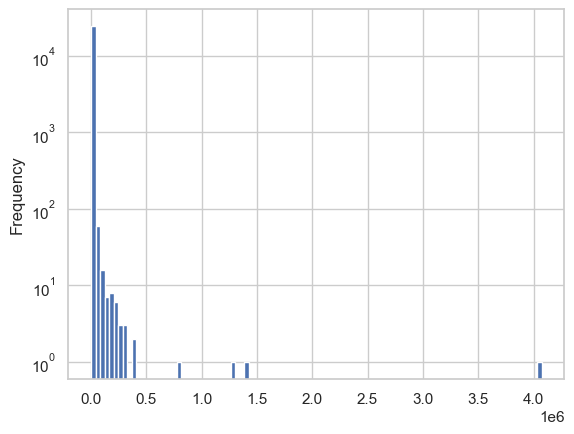

In [119]:
df_complete["claim_amount"].plot.hist(bins=100, log=True)

 Zudem gibt es einige Ausreißer mit außergewöhnlich hohen Schadenhöhen, die die Prognosen stark beeinflussen könnte. Alle Schadenhöhen über 500.000€ (4 Beobachtungen) wurden für die Modelierung vorerst entfernt.

In [120]:
df_complete["claim_amount"].sort_values(ascending=False).head(10)

7487     4075400.56
2842     1404185.52
12729    1301172.60
17083     774411.50
9764      399213.66
15353     382955.14
7357      307096.42
3800      301635.49
16181     287423.00
17788     281897.49
Name: claim_amount, dtype: float64

 Einige der Prädiktoren sind ebenfalls rechtsschief und werden logarithmiert.

<Axes: ylabel='Density'>

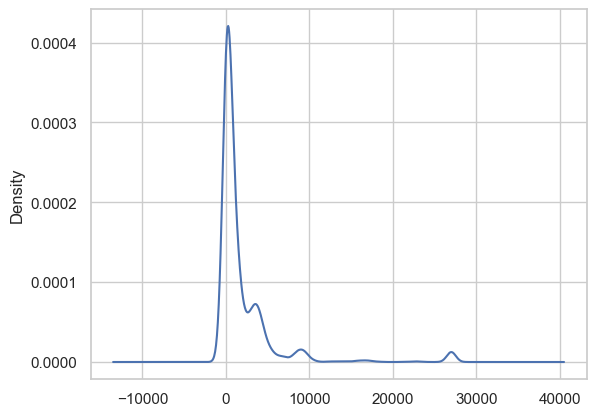

In [121]:
df_complete["population_density"].plot.density()

<Axes: ylabel='Density'>

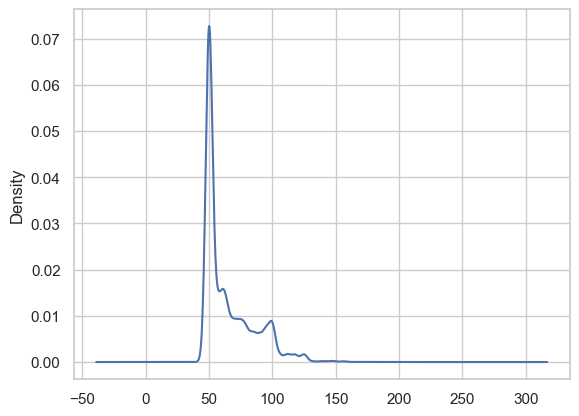

In [122]:
df_complete["bonus_malus"].plot.density()

 ### Numerische zu kategorischen Variablen
 Nur sehr wenige Versicherungsnehmer haben mehr als 2 Schäden pro Jahr, daher wird die `number_claims` Variable auf drei Kategorien reduziert: 1, 2 und 3 oder mehr.

In [123]:
df_complete["number_claims"].value_counts(sort=True, ascending=False)

number_claims
1     23570
2      1299
3        62
4         5
5         2
11        2
6         1
8         1
16        1
9         1
Name: count, dtype: int64

 Die numerische `driver_age` Variable wird in Altersgruppen in 5-Jahres-Schritten unterteilt, da der Zusammenhang zwischen Alter und Schadenhöhe nicht linear ist. Alternativ könnten auch polynomiale Terme mit in das Modell aufgenommen werden.

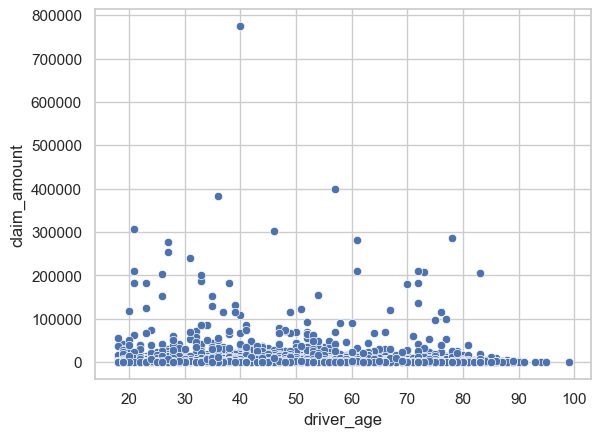

In [124]:
plot_claims_vs_age(df_complete)

 ### Binäre Variablen zu Booleans
 Die `vehicle_gas` Variable hat nur die beiden Ausprägungen "Regular" und "Diesel", daher wird sie als binäre Variable kodiert.

In [125]:
df_complete["vehicle_gas"].value_counts(sort=True, ascending=False)

vehicle_gas
Diesel     12700
Regular    12244
Name: count, dtype: int64

 ### Finaler Datensatz zur Modellierung:
 Die Zielvariable zur Modellierung ist `log_claim_amount_per_year`, also die logarithmierte Schadenhöhe pro Versicherungsnehmer und Jahr.

 Die verwendeten Prädiktoren sind:
 - `number_claims`: Anzahl der Schäden pro Versicherungsnehmer
 - `driver_age_groups`: Altersgruppe des Versicherungsnehmers
 - `log_bonus_malus`: Bonus-Malus-Stufe des Versicherungsnehmers
 - `vehicle_age`: Alter des Fahrzeugs
 - `vehicle_brand`: Marke des Fahrzeugs
 - `vehicle_power`: Leistung des Fahrzeugs
 - `is_diesel`: Fahrzeug mit Diesel-Motor oder nicht
 - `area_code`: Geographische Region
 - `region`: Geographische Region
 - `log_population_density`: Logarithmierte Bevölkerungsdichte der Region

In [126]:
X_train = pd.read_parquet(DataPaths.processed.X_train)
y_train = pd.read_parquet(DataPaths.processed.y_train)

X_train

,number_claims_binned,driver_age_groups,log_bonus_malus,vehicle_age,vehicle_brand,vehicle_power,is_diesel,area_code,region,log_population_density
12796,"(0, 1]","(30, 35]",4.219508,30,B1,4,False,D,R11,6.679599
3479,"(0, 1]","(40, 45]",4.499810,10,B2,4,False,B,R53,4.543295
15779,"(0, 1]","(35, 40]",3.912023,6,B1,5,False,C,R53,5.659482
12538,"(0, 1]","(20, 25]",4.605170,8,B2,7,False,E,R82,7.719574
20105,"(0, 1]","(25, 30]",4.158883,1,B12,7,False,C,R52,5.420535
...,...,...,...,...,...,...,...,...,...,...
21575,"(0, 1]","(35, 40]",3.931826,11,B1,6,True,C,R82,4.744932
5390,"(0, 1]","(25, 30]",4.330733,13,B2,4,False,C,R52,5.030438
860,"(0, 1]","(45, 50]",4.127134,11,B2,10,True,D,R24,6.608001
15795,"(0, 1]","(35, 40]",4.060443,3,B2,4,False,B,R24,4.276666


In [127]:
y_train

,log_claim_amount_per_year
12796,7.739812
3479,6.498235
15779,7.968965
12538,8.709276
20105,6.406311
...,...
21575,7.421909
5390,4.553456
860,7.028308
15795,7.093405


 ## Modellierung
 5 Modelle in aufsteigender Komplexität:
 1. **Baseline**: konstante Vorhersage = Mittelwert der Zielvariable
 2. **Lineare Regression**: einfaches und interpretierbares Modell
 3. **Lasso Regression**: robuster als Lineare Regression und implizite Feature Selection
 4. **Random Forest**: Bagging Ensemble
 5. **XGBoost**: Boosting Ensemble


 ### Hyperparameter Tuning
 Lasso Regression, Random Forest und XGBoost werden mit Randomized Search 5-Fold Cross Validation inklusive Hyperparameter Tuning trainiert. Insgesamt wurden maximal 100 Hyperparameterkombination pro Modell ausgewertet.
 
 Die besten Hyperparameter sind:

In [128]:
lasso_regression_fit = load_model(ModelPaths.lasso_regression)
lasso_regression_hyperparams = extract_hyperparams(lasso_regression_fit)

random_forest_fit = load_model(ModelPaths.random_forest)
random_forest_hyperparams = extract_hyperparams(random_forest_fit)

xgboost_fit = load_model(ModelPaths.xgboost)
xgboost_hyperparams = extract_hyperparams(xgboost_fit)

print("Lasso Regression Hyperparameter:", lasso_regression_hyperparams)
print("Random Forest Hyperparameter:", random_forest_hyperparams)
print("XGBoost Hyperparameter:", xgboost_hyperparams)

Lasso Regression Hyperparameter: {'alpha': 0.01}
Random Forest Hyperparameter: {'n_estimators': 700, 'min_samples_leaf': 3, 'max_depth': 6}
XGBoost Hyperparameter: {'subsample': 0.7, 'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 0.7}


 ## Evaluation
 ### Performance Vergleich
 Als Metriken für das Regressionsproblem werden der Mean Absolute Error (MAE) und der Mean Squared Error (MSE) verwendet.

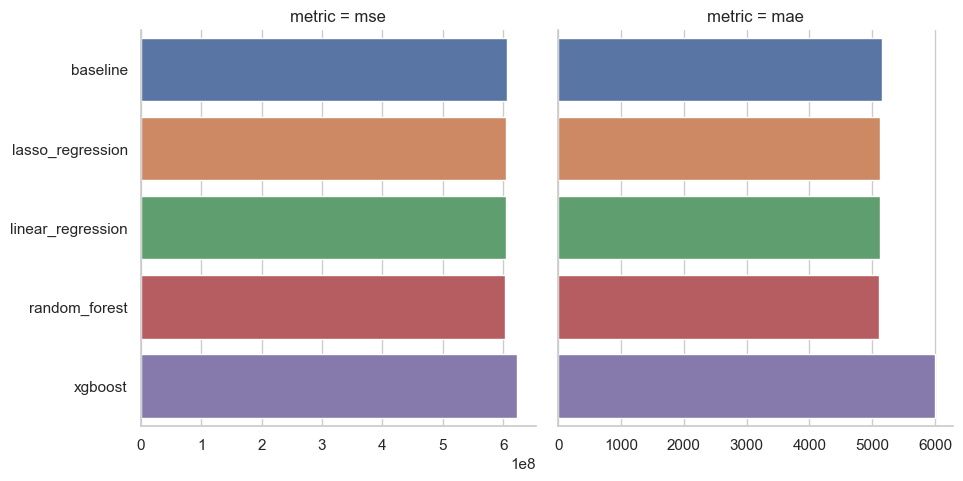

In [129]:
predictions_frame = pd.read_parquet(DataPaths.results.predictions)

plot_performance_metrics(predictions_frame)

 ### Predictions vs True Values für Random Forest

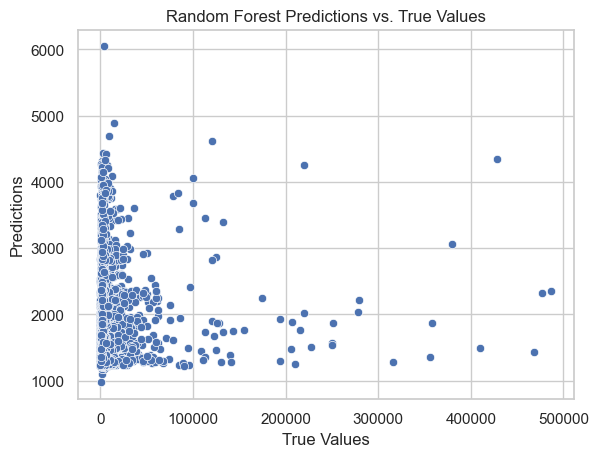

In [130]:
plot_random_forest_predictions(predictions_frame)

 ### Coefficients & Feature Importances

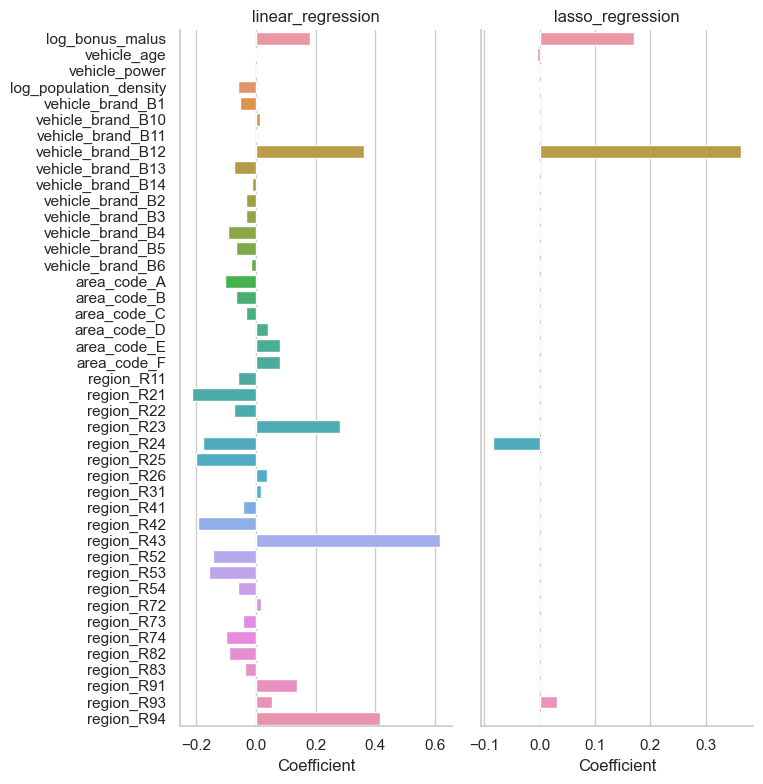

In [131]:
coefficients_data = collect_coefficients_data()

plot_coefficients(coefficients_data)

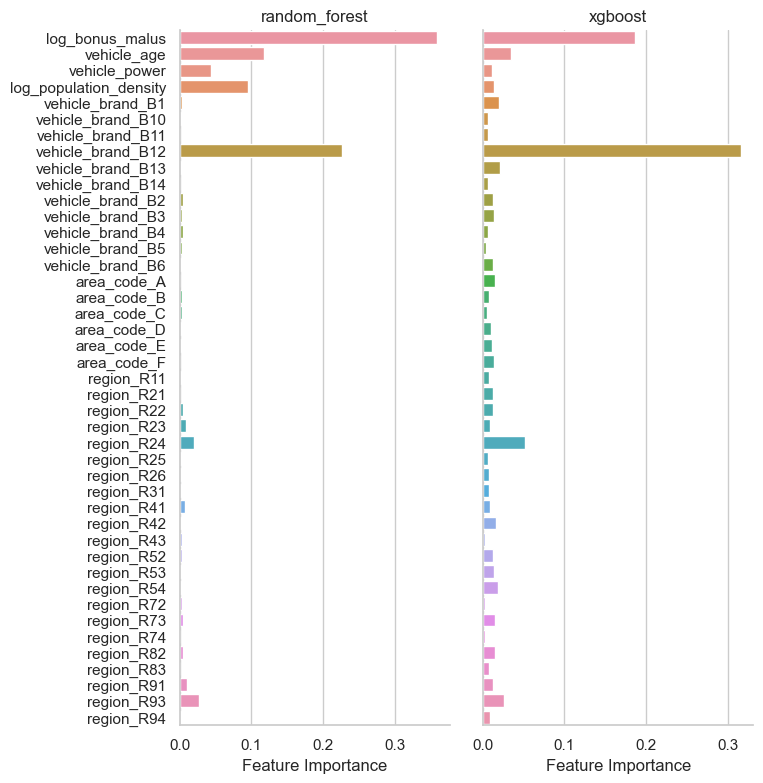

In [132]:
plot_feature_importances(coefficients_data)

## Fazit


### Verbeserungsansätze

#### Preprocessing

- Ausreißer nicht einfach rauswerfen, sondern erst genauer untersuchen, ob sie dem Modell wichtige Informationen liefern
- Ähnlich wie bei der `driver_age` Variablen mehr bivariate Zusammenhänge untersuchen und ggf. polynomiale Terme oder Interaktionsterme in das Modell aufnehmen
- Die Lasso Regression hat gezeigt, dass einige Features wenig Einfluss auf die Zielvariable haben. Diese Features können durch Feature Selection vor der Modellierung entfernt werden, um die Modellkomplexität zu reduzieren (geringere Gefahr des Overfittings) und das Modell interpretierbarer zu machen.

### Modellierung

- Extensiveres Hyperparameter Tuning und systematischere Bestimmung der Hyperparameter Ranges für die Randomized Search
- Gegebenenfalls weitere Modelle testen


#### Sonstiges

- **Unit Tests**
- Schönere (ggf. interaktive) Plots
- Bessere Dokumentation und vollständige Docstrings